# 3년치 데이터 정방향 학습 & 예측

In [1]:
!pip install tf-nightly

In [2]:
import tensorflow as tf
import tensorflow.keras.layers
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Nadam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


train data % : 1.8800000000000001 test data % : 0.0
Epoch 1/500
17/17 [==============================] - 4s 69ms/step - loss: 0.4105 - accuracy: 0.8801 - val_loss: 2.0151e-05 - val_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 0.00002, saving model to /content/gdrive/My Drive/Colab Notebooks/model/stock_02.hdf5
Epoch 2/500
17/17 [==============================] - 1s 30ms/step - loss: 0.1329 - accuracy: 0.9874 - val_loss: 7.1744e-05 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00002
Epoch 3/500
17/17 [==============================] - 0s 29ms/step - loss: 0.1229 - accuracy: 0.9799 - val_loss: 0.0019 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00002
Epoch 4/500
17/17 [==============================] - 1s 31ms/step - loss: 0.1373 - accuracy: 0.9754 - val_loss: 0.0012 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00002
Epoch 5/500
17/17 [==============================] - 1s 32ms/step - loss: 0.1101 - acc

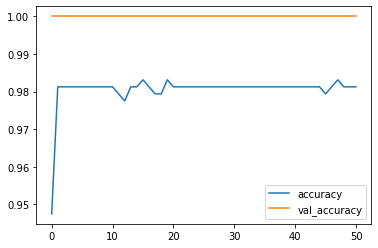

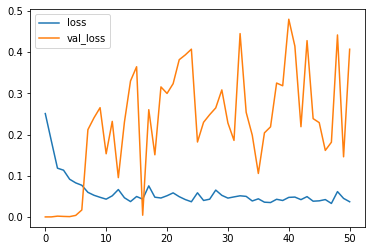

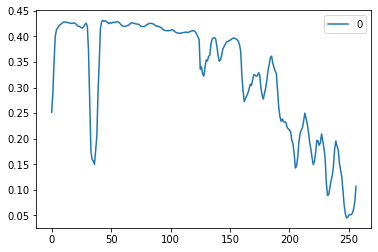

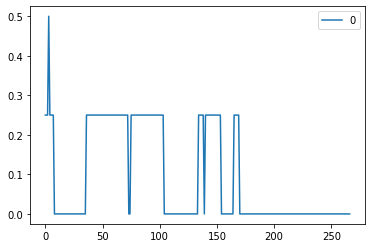

In [3]:
df = pd.read_csv("/content/gdrive/My Drive/SBUX_rev.2.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']
df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = (df['mov5'].shift(-1) - df['mov5'])/df['mov5']
df['1w'] = (df['mov5'].shift(-5) - df['mov5'])/df['mov5']
df['2w'] = (df['mov5'].shift(-10) - df['mov5'])/df['mov5']
df['4w'] = (df['mov5'].shift(-20) - df['mov5'])/df['mov5']
df['6w'] = (df['mov5'].shift(-30) - df['mov5'])/df['mov5']
df['8w'] = (df['mov5'].shift(-40) - df['mov5'])/df['mov5']
df['10w'] = (df['mov5'].shift(-50) - df['mov5'])/df['mov5']
df['12w'] = (df['mov5'].shift(-60) - df['mov5'])/df['mov5']
df['18w'] = (df['mov5'].shift(-90) - df['mov5'])/df['mov5']
df['24w'] = (df['mov5'].shift(-120) - df['mov5'])/df['mov5']
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5']

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,5] + np.sort(df.iloc[:,14:],axis=1)[:,4] + np.sort(df.iloc[:,14:],axis=1)[:,3])/3

df = df.dropna(axis=0)
df = df.iloc[-800:,:]

df['return'].describe()

def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1     # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2     # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3            # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

from tensorflow.keras.callbacks import ModelCheckpoint

modelpath = "/content/gdrive/My Drive/Colab Notebooks/model/stock_02.hdf5"
checkpointer = ModelCheckpoint(filepath = modelpath, monitor = 'val_loss', verbose = 1, save_best_only = True)

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 50)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GRU

# EnSemble을 만들기 위한 사전 작업 : model1 : 전체 데이터 작업

i = Input(shape=(T,D))

lstm = LSTM(100, dropout=0.2, recurrent_dropout=0.2)
left_input = Input(shape=(T,D))
left_output = lstm(left_input)

gru = GRU(100,  dropout=0.2, recurrent_dropout=0.2)
right_input = Input(shape= (T,D))
right_output = gru(right_input)

# merge
merged = tf.keras.layers.concatenate([left_output, right_output], axis = -1)
merged = Dropout(rate=0.7)(merged)
merged = Dense(256, activation='relu')(merged)
merged = Dropout(rate=0.7)(merged)
merged = Dense(5, LeakyReLU(alpha=0.1))(merged)
predictions = tf.keras.layers.Dense(1, activation = 'sigmoid')(merged)


model = Model([left_input, right_input], predictions)

model.compile(
    loss = 'binary_crossentropy',
    sample_weight_mode = 'temporal',
    optimizer = Adam(lr = 0.001),
    metrics = ['accuracy'],
)

# 모델 객체 만들고 훈련
r = model.fit([X_train, X_train], 
          Y_train,
          batch_size = 32,
          epochs = 500,
          validation_data = ([X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_test, X_test])).plot()
pd.DataFrame(target[Ntrain:]).plot()


train data % : 55.120000000000005 test data % : 22.12
Epoch 1/500
17/17 [==============================] - 3s 64ms/step - loss: 1.3912 - accuracy: 0.4578 - val_loss: 0.6123 - val_accuracy: 0.7704

Epoch 00001: val_loss did not improve from 0.00002
Epoch 2/500
17/17 [==============================] - 1s 33ms/step - loss: 0.6019 - accuracy: 0.7674 - val_loss: 0.4955 - val_accuracy: 0.8677

Epoch 00002: val_loss did not improve from 0.00002
Epoch 3/500
17/17 [==============================] - 1s 33ms/step - loss: 0.4716 - accuracy: 0.8649 - val_loss: 0.2894 - val_accuracy: 0.8755

Epoch 00003: val_loss did not improve from 0.00002
Epoch 4/500
17/17 [==============================] - 1s 30ms/step - loss: 0.3269 - accuracy: 0.8931 - val_loss: 0.2105 - val_accuracy: 0.9183

Epoch 00004: val_loss did not improve from 0.00002
Epoch 5/500
17/17 [==============================] - 1s 30ms/step - loss: 0.3048 - accuracy: 0.8987 - val_loss: 0.3664 - val_accuracy: 0.8366

Epoch 00005: val_loss did n

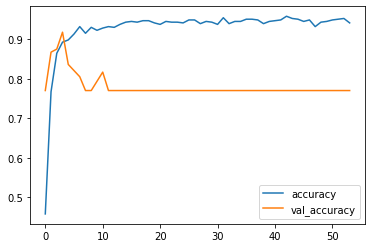

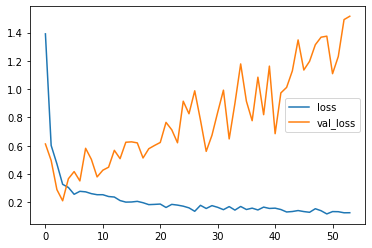

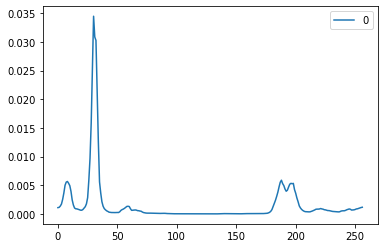

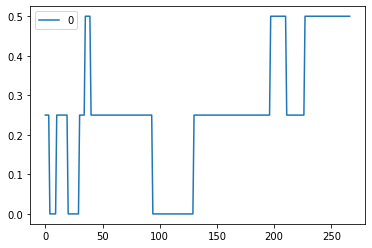

In [4]:
df = pd.read_csv("/content/gdrive/My Drive/AMZN.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']
df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = (df['mov5'].shift(-1) - df['mov5'])/df['mov5']
df['1m'] = (df['mov5'].shift(-20) - df['mov5'])/df['mov5']
df['2m'] = (df['mov5'].shift(-40) - df['mov5'])/df['mov5']
df['3m'] = (df['mov5'].shift(-60) - df['mov5'])/df['mov5']
df['6m'] = (df['mov5'].shift(-120) - df['mov5'])/df['mov5']
df['12m'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5']

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,5] + np.sort(df.iloc[:,14:],axis=1)[:,4] + np.sort(df.iloc[:,14:],axis=1)[:,3])/3

df = df.dropna(axis=0)
df = df.iloc[-800:,:]

df['return'].describe()

def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1     # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2     # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3            # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02.hdf5")

# 모델 객체 만들고 훈련

r = model.fit([X_train, X_train], 
          Y_train,
          batch_size = 32,
          epochs = 500,
          validation_data = ([X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_test, X_test])).plot()
pd.DataFrame(target[Ntrain:]).plot()


train data % : 63.94 test data % : 92.62
Epoch 1/500
17/17 [==============================] - 3s 60ms/step - loss: 1.8079 - accuracy: 0.3621 - val_loss: 0.8619 - val_accuracy: 0.0389

Epoch 00001: val_loss did not improve from 0.00002
Epoch 2/500
17/17 [==============================] - 1s 31ms/step - loss: 0.6870 - accuracy: 0.5610 - val_loss: 0.6670 - val_accuracy: 0.9611

Epoch 00002: val_loss did not improve from 0.00002
Epoch 3/500
17/17 [==============================] - 1s 31ms/step - loss: 0.6716 - accuracy: 0.6435 - val_loss: 0.6164 - val_accuracy: 0.9611

Epoch 00003: val_loss did not improve from 0.00002
Epoch 4/500
17/17 [==============================] - 1s 32ms/step - loss: 0.6346 - accuracy: 0.6829 - val_loss: 0.6080 - val_accuracy: 0.9611

Epoch 00004: val_loss did not improve from 0.00002
Epoch 5/500
17/17 [==============================] - 1s 33ms/step - loss: 0.5804 - accuracy: 0.7167 - val_loss: 0.6704 - val_accuracy: 0.5953

Epoch 00005: val_loss did not improve fr

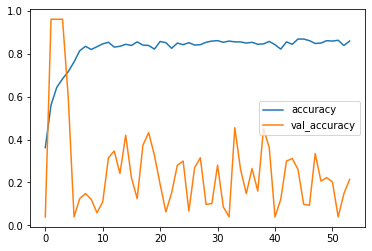

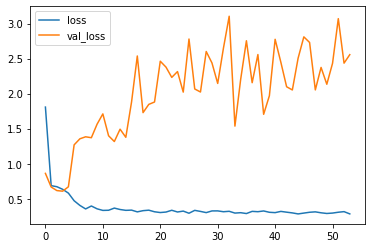

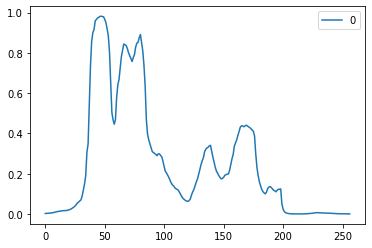

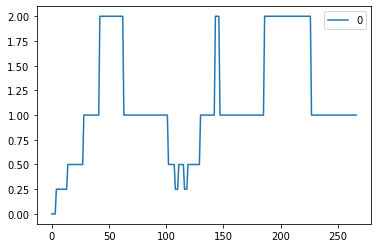

In [5]:
df = pd.read_csv("/content/gdrive/My Drive/AAPL.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']
df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = (df['mov5'].shift(-1) - df['mov5'])/df['mov5']
df['1m'] = (df['mov5'].shift(-20) - df['mov5'])/df['mov5']
df['2m'] = (df['mov5'].shift(-40) - df['mov5'])/df['mov5']
df['3m'] = (df['mov5'].shift(-60) - df['mov5'])/df['mov5']
df['6m'] = (df['mov5'].shift(-120) - df['mov5'])/df['mov5']
df['12m'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5']

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,5] + np.sort(df.iloc[:,14:],axis=1)[:,4] + np.sort(df.iloc[:,14:],axis=1)[:,3])/3

df = df.dropna(axis=0)
df = df.iloc[-800:,:]

df['return'].describe()

def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1     # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2     # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3            # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result


df['return02'] = df.apply(scaler01,axis=1)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02.hdf5")

# 모델 객체 만들고 훈련


r = model.fit([X_train, X_train], 
          Y_train,
          batch_size = 32,
          epochs = 500,
          validation_data = ([X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_test, X_test])).plot()
pd.DataFrame(target[Ntrain:]).plot()


train data % : 49.309999999999995 test data % : 57.379999999999995
Epoch 1/500
17/17 [==============================] - 3s 59ms/step - loss: 1.3306 - accuracy: 0.5084 - val_loss: 0.8545 - val_accuracy: 0.4047

Epoch 00001: val_loss did not improve from 0.00002
Epoch 2/500
17/17 [==============================] - 1s 30ms/step - loss: 0.6043 - accuracy: 0.6811 - val_loss: 0.7819 - val_accuracy: 0.4047

Epoch 00002: val_loss did not improve from 0.00002
Epoch 3/500
17/17 [==============================] - 1s 31ms/step - loss: 0.5514 - accuracy: 0.7467 - val_loss: 1.0959 - val_accuracy: 0.4047

Epoch 00003: val_loss did not improve from 0.00002
Epoch 4/500
17/17 [==============================] - 1s 30ms/step - loss: 0.5090 - accuracy: 0.7598 - val_loss: 1.1238 - val_accuracy: 0.4047

Epoch 00004: val_loss did not improve from 0.00002
Epoch 5/500
17/17 [==============================] - 1s 32ms/step - loss: 0.4766 - accuracy: 0.7767 - val_loss: 1.3870 - val_accuracy: 0.4047

Epoch 00005: v

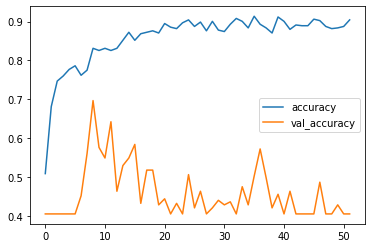

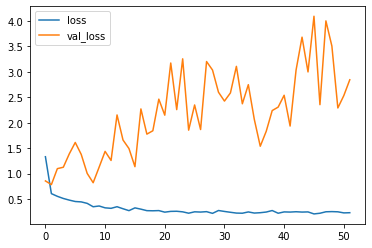

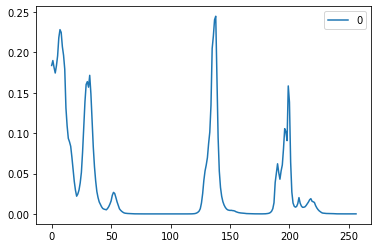

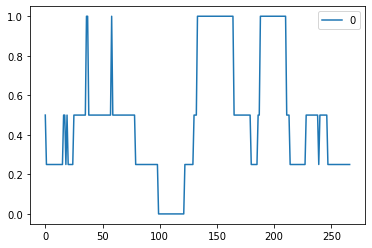

In [6]:
df = pd.read_csv("/content/gdrive/My Drive/INTC.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']
df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = (df['mov5'].shift(-1) - df['mov5'])/df['mov5']
df['1m'] = (df['mov5'].shift(-20) - df['mov5'])/df['mov5']
df['2m'] = (df['mov5'].shift(-40) - df['mov5'])/df['mov5']
df['3m'] = (df['mov5'].shift(-60) - df['mov5'])/df['mov5']
df['6m'] = (df['mov5'].shift(-120) - df['mov5'])/df['mov5']
df['12m'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5']

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,5] + np.sort(df.iloc[:,14:],axis=1)[:,4] + np.sort(df.iloc[:,14:],axis=1)[:,3])/3

df = df.dropna(axis=0)
df = df.iloc[-800:,:]

df['return'].describe()

def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1     # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2     # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3            # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02.hdf5")

# 모델 객체 만들고 훈련

r = model.fit([X_train, X_train], 
          Y_train,
          batch_size = 32,
          epochs = 500,
          validation_data = ([X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_test, X_test])).plot()
pd.DataFrame(target[Ntrain:]).plot()


train data % : 77.44 test data % : 96.37
Epoch 1/500
17/17 [==============================] - 3s 57ms/step - loss: 2.0403 - accuracy: 0.2364 - val_loss: 0.7013 - val_accuracy: 0.0467

Epoch 00001: val_loss did not improve from 0.00002
Epoch 2/500
17/17 [==============================] - 1s 47ms/step - loss: 0.6639 - accuracy: 0.6829 - val_loss: 0.4374 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00002
Epoch 3/500
17/17 [==============================] - 1s 30ms/step - loss: 0.5990 - accuracy: 0.7749 - val_loss: 0.2349 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00002
Epoch 4/500
17/17 [==============================] - 1s 30ms/step - loss: 0.5546 - accuracy: 0.7749 - val_loss: 0.2390 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00002
Epoch 5/500
17/17 [==============================] - 1s 30ms/step - loss: 0.5119 - accuracy: 0.7749 - val_loss: 0.1605 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve fr

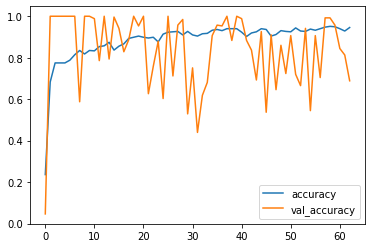

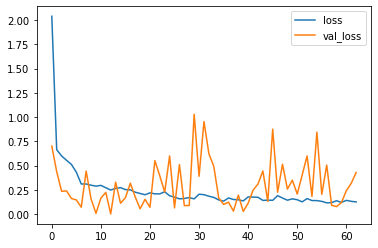

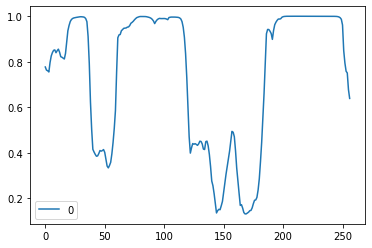

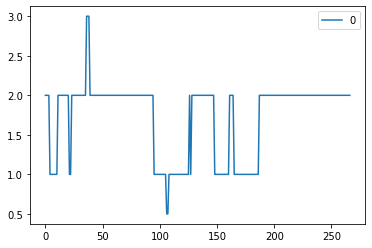

In [7]:
df = pd.read_csv("/content/gdrive/My Drive/AMD.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']
df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = (df['mov5'].shift(-1) - df['mov5'])/df['mov5']
df['1m'] = (df['mov5'].shift(-20) - df['mov5'])/df['mov5']
df['2m'] = (df['mov5'].shift(-40) - df['mov5'])/df['mov5']
df['3m'] = (df['mov5'].shift(-60) - df['mov5'])/df['mov5']
df['6m'] = (df['mov5'].shift(-120) - df['mov5'])/df['mov5']
df['12m'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5']

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,5] + np.sort(df.iloc[:,14:],axis=1)[:,4] + np.sort(df.iloc[:,14:],axis=1)[:,3])/3

df = df.dropna(axis=0)
df = df.iloc[-800:,:]

df['return'].describe()

def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1     # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2     # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3            # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02.hdf5")

# 모델 객체 만들고 훈련
r = model.fit([X_train, X_train], 
          Y_train,
          batch_size = 32,
          epochs = 500,
          validation_data = ([X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_test, X_test])).plot()
pd.DataFrame(target[Ntrain:]).plot()


train data % : 35.06 test data % : 77.62
Epoch 1/500
17/17 [==============================] - 3s 58ms/step - loss: 0.9745 - accuracy: 0.6492 - val_loss: 0.9586 - val_accuracy: 0.1946

Epoch 00001: val_loss did not improve from 0.00002
Epoch 2/500
17/17 [==============================] - 1s 32ms/step - loss: 0.5656 - accuracy: 0.6773 - val_loss: 0.8948 - val_accuracy: 0.1946

Epoch 00002: val_loss did not improve from 0.00002
Epoch 3/500
17/17 [==============================] - 1s 31ms/step - loss: 0.5317 - accuracy: 0.7073 - val_loss: 1.0859 - val_accuracy: 0.1946

Epoch 00003: val_loss did not improve from 0.00002
Epoch 4/500
17/17 [==============================] - 1s 33ms/step - loss: 0.4888 - accuracy: 0.7749 - val_loss: 0.9128 - val_accuracy: 0.2646

Epoch 00004: val_loss did not improve from 0.00002
Epoch 5/500
17/17 [==============================] - 1s 31ms/step - loss: 0.4348 - accuracy: 0.8105 - val_loss: 0.8623 - val_accuracy: 0.5720

Epoch 00005: val_loss did not improve fr

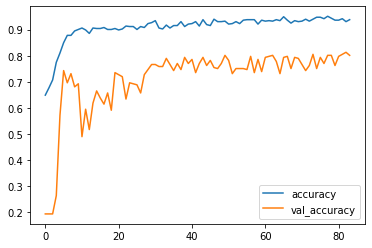

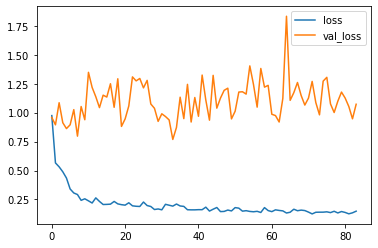

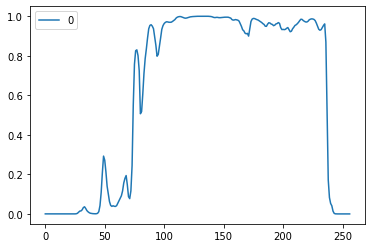

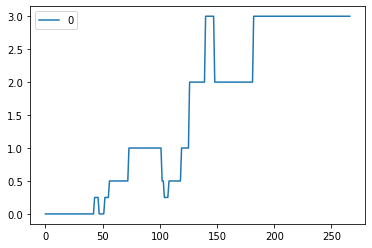

In [8]:
df = pd.read_csv("/content/gdrive/My Drive/TSLA.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']
df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = (df['mov5'].shift(-1) - df['mov5'])/df['mov5']
df['1m'] = (df['mov5'].shift(-20) - df['mov5'])/df['mov5']
df['2m'] = (df['mov5'].shift(-40) - df['mov5'])/df['mov5']
df['3m'] = (df['mov5'].shift(-60) - df['mov5'])/df['mov5']
df['6m'] = (df['mov5'].shift(-120) - df['mov5'])/df['mov5']
df['12m'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5']

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,5] + np.sort(df.iloc[:,14:],axis=1)[:,4] + np.sort(df.iloc[:,14:],axis=1)[:,3])/3

df = df.dropna(axis=0)
df = df.iloc[-800:,:]

df['return'].describe()

def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1     # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2     # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3            # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02.hdf5")

# 모델 객체 만들고 훈련
r = model.fit([X_train, X_train], 
          Y_train,
          batch_size = 32,
          epochs = 500,
          validation_data = ([X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_test, X_test])).plot()
pd.DataFrame(target[Ntrain:]).plot()


train data % : 23.62 test data % : 47.620000000000005
Epoch 1/500
17/17 [==============================] - 3s 58ms/step - loss: 0.9053 - accuracy: 0.7636 - val_loss: 0.9107 - val_accuracy: 0.5058

Epoch 00001: val_loss did not improve from 0.00002
Epoch 2/500
17/17 [==============================] - 1s 32ms/step - loss: 0.4940 - accuracy: 0.7674 - val_loss: 1.0092 - val_accuracy: 0.5058

Epoch 00002: val_loss did not improve from 0.00002
Epoch 3/500
17/17 [==============================] - 1s 34ms/step - loss: 0.3933 - accuracy: 0.7955 - val_loss: 1.3664 - val_accuracy: 0.5058

Epoch 00003: val_loss did not improve from 0.00002
Epoch 4/500
17/17 [==============================] - 1s 46ms/step - loss: 0.2468 - accuracy: 0.9212 - val_loss: 1.2575 - val_accuracy: 0.6887

Epoch 00004: val_loss did not improve from 0.00002
Epoch 5/500
17/17 [==============================] - 1s 30ms/step - loss: 0.1083 - accuracy: 0.9719 - val_loss: 3.9934 - val_accuracy: 0.5214

Epoch 00005: val_loss did n

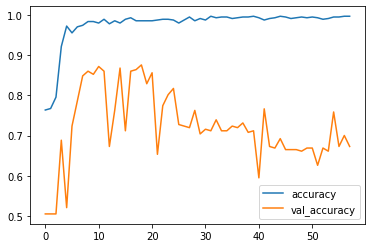

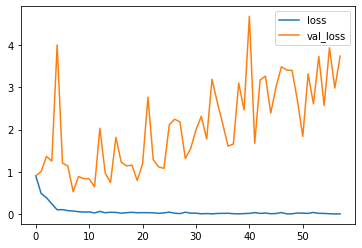

예측 결과 : 43.62537
실제 결과: 127.0
학습된 모델은 미래를 65.64999999999999 %  비관적으로 전망하고 있습니다.


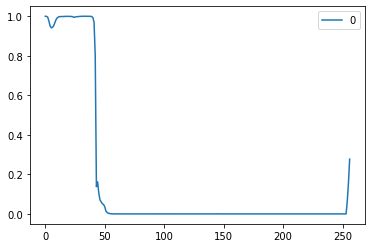

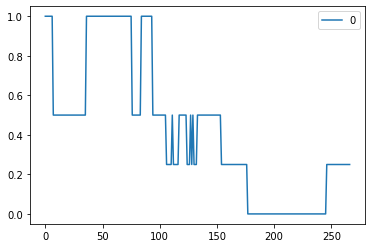

In [9]:
df = pd.read_csv("/content/gdrive/My Drive/SBUX_rev.2.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']
df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = (df['mov5'].shift(-1) - df['mov5'])/df['mov5']
df['1m'] = (df['mov5'].shift(-20) - df['mov5'])/df['mov5']
df['2m'] = (df['mov5'].shift(-40) - df['mov5'])/df['mov5']
df['3m'] = (df['mov5'].shift(-60) - df['mov5'])/df['mov5']
df['6m'] = (df['mov5'].shift(-120) - df['mov5'])/df['mov5']
df['12m'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5']

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,5] + np.sort(df.iloc[:,14:],axis=1)[:,4] + np.sort(df.iloc[:,14:],axis=1)[:,3])/3

df = df.dropna(axis=0)
df = df.iloc[-800:,:]

df['return'].describe()

def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1     # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2     # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3            # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 10
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_02.hdf5")

# 모델 객체 만들고 훈련
r = model.fit([X_train, X_train], 
          Y_train,
          batch_size = 32,
          epochs = 500,
          validation_data = ([X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pred = model.predict([X_test, X_test]).sum()
print("예측 결과 :",pred)
print("실제 결과:",Y_test.sum())
if pred > Y_test.sum() :
  print("학습된 모델은 미래를",round((pred-Y_test.sum())/Y_test.sum(),4)*100,"% 낙관적으로 전망하고 있습니다.")
else :
  print("학습된 모델은 미래를",round((Y_test.sum()-pred)/Y_test.sum(),4)*100,"%  비관적으로 전망하고 있습니다.")

pd.DataFrame(model.predict([X_test, X_test])).plot()
pd.DataFrame(target[Ntrain:]).plot()
